In [74]:
import pyforest
from updated_RF import *
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef

from rdkit import Chem
from rdkit.Chem import AllChem


import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import matplotlib 
# matplotlib.use('Agg')

from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV

In [75]:
gp_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/gp_kfold_results/'
rf_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/rf_models/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
folds=['fold1','fold2','fold3','fold4','fold5'] 

In [77]:
# RF kfold Results
rf = pd.read_csv(f'{rf_results}RF_test_results_all_NEK_kfold_val_10x.csv')
rf['1-specificity']=1-rf['specificity']
rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]
rf=rf.replace('none_scaled', 'no_sampling')


rf_raw = rf[(rf['strategy'] == 'no_sampling') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 
total_rf['strategy'] =total_rf['strategy'].astype(str) +'_'+ total_rf['RF_type']

binding = total_rf[total_rf['nek type'] == 'binding'] 
inhib = total_rf[total_rf['nek type'] == 'inhibition'] 


In [78]:
samp_palette={'no_sampling': 'tab:blue', 'UNDER':'tab:orange', 'SMOTE': 'hotpink', 'ADASYN':'tab:red', 
             'no_sampling_RF': 'cornflowerblue', 'no_sampling_RF_BCW': 'lavender', 'UNDER_RF': 'orange', 
             'no_sampling_BRFC': 'blue', 'SMOTE_RF': 'hotpink', 'ADASYN_RF': 'red', 
             'no_sampling_BRFC_BCW': 'black'}

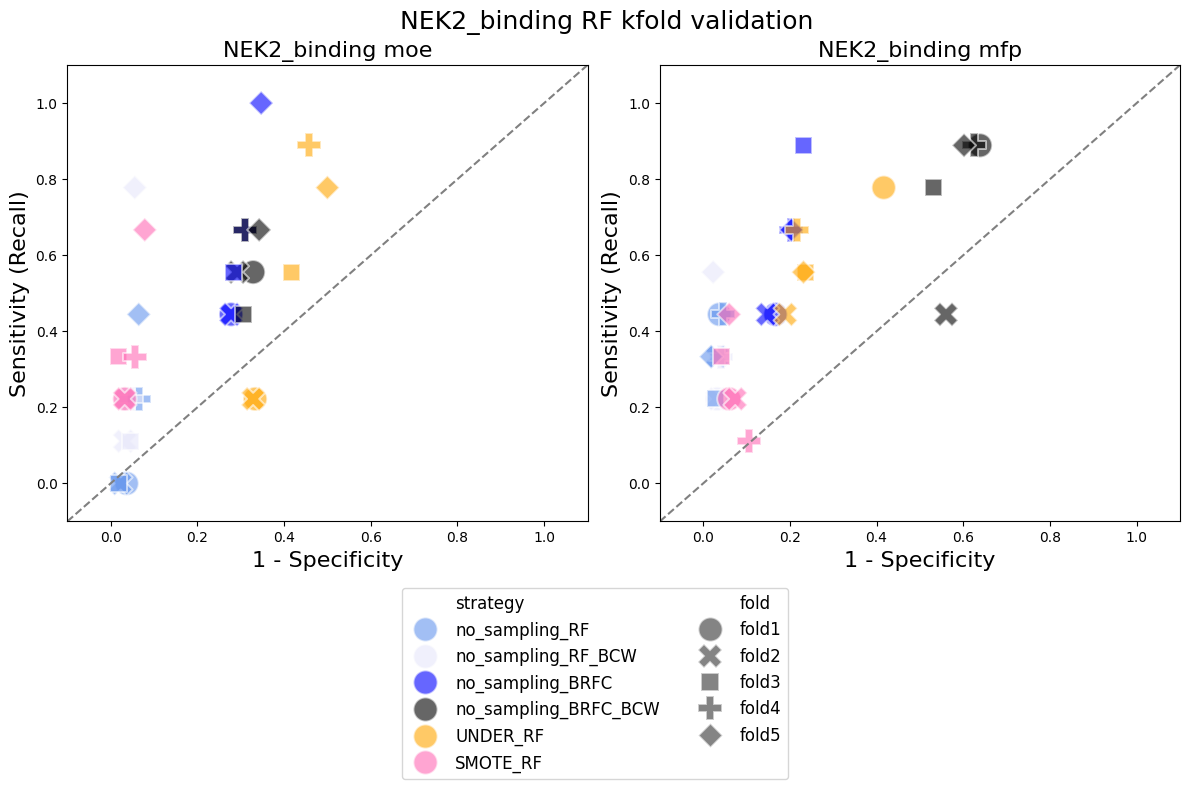

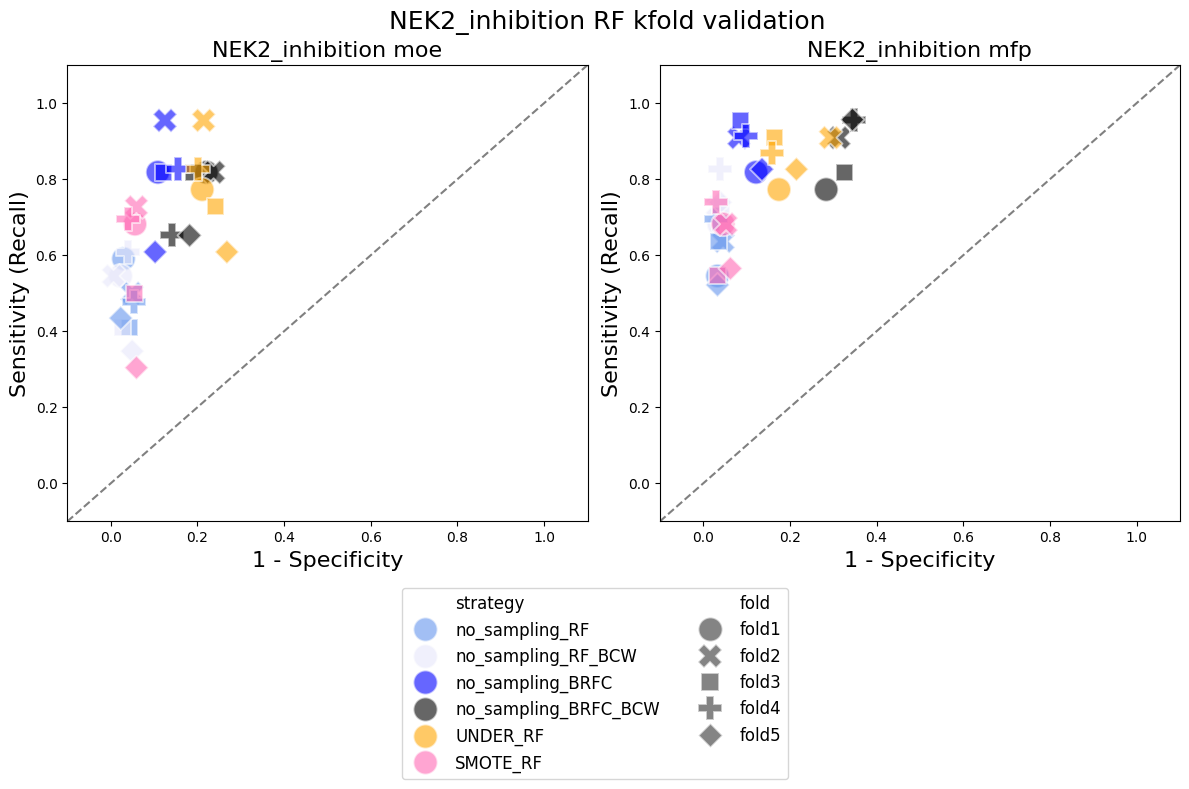

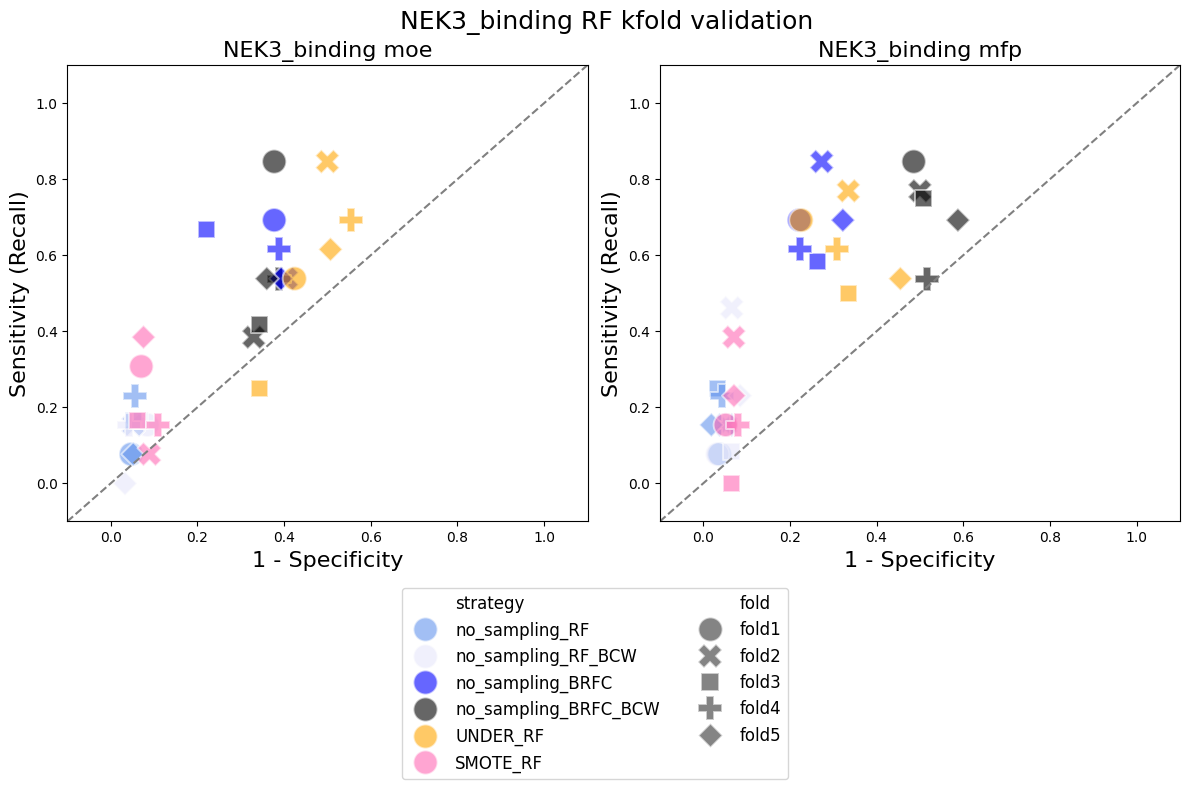

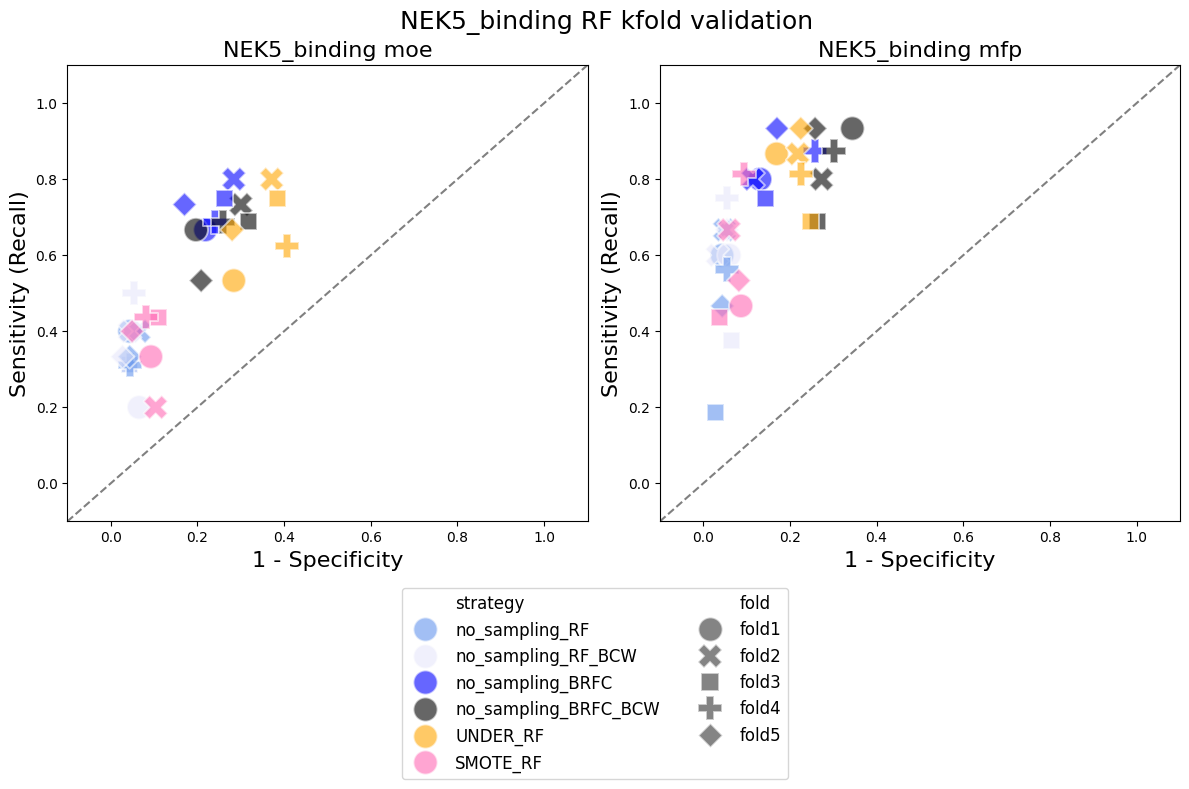

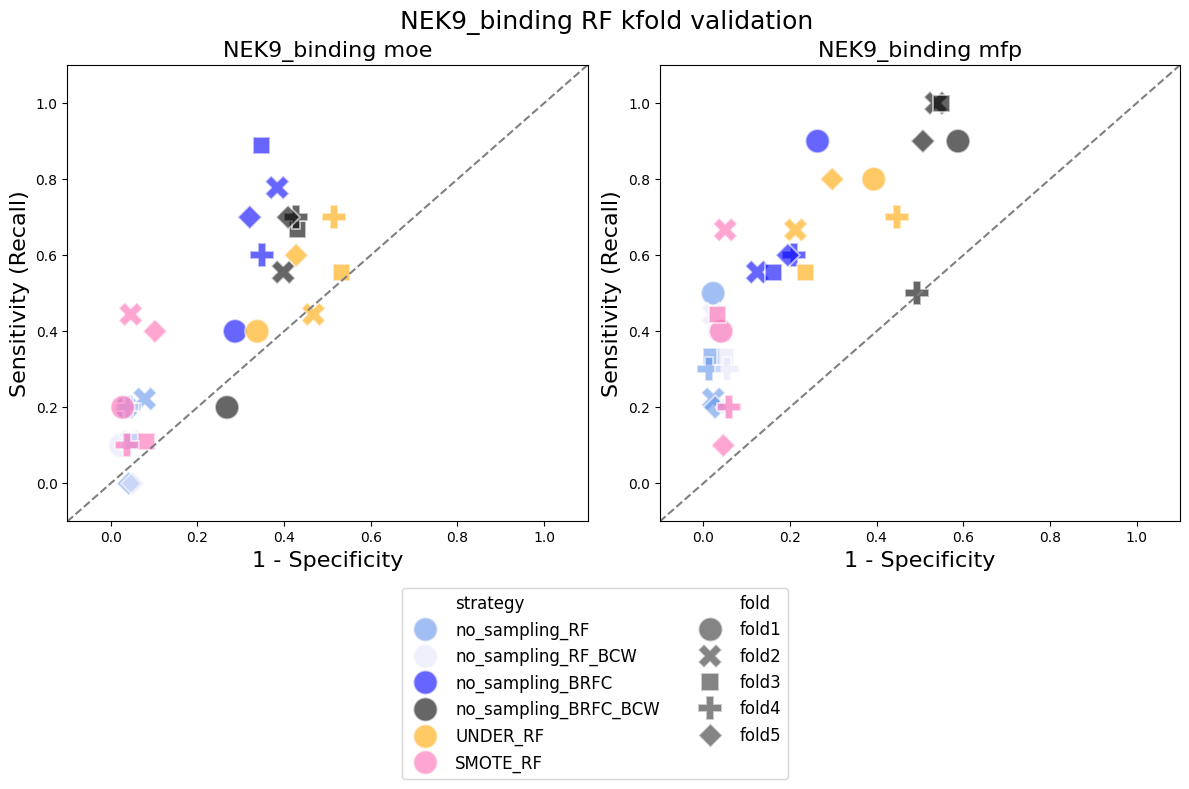

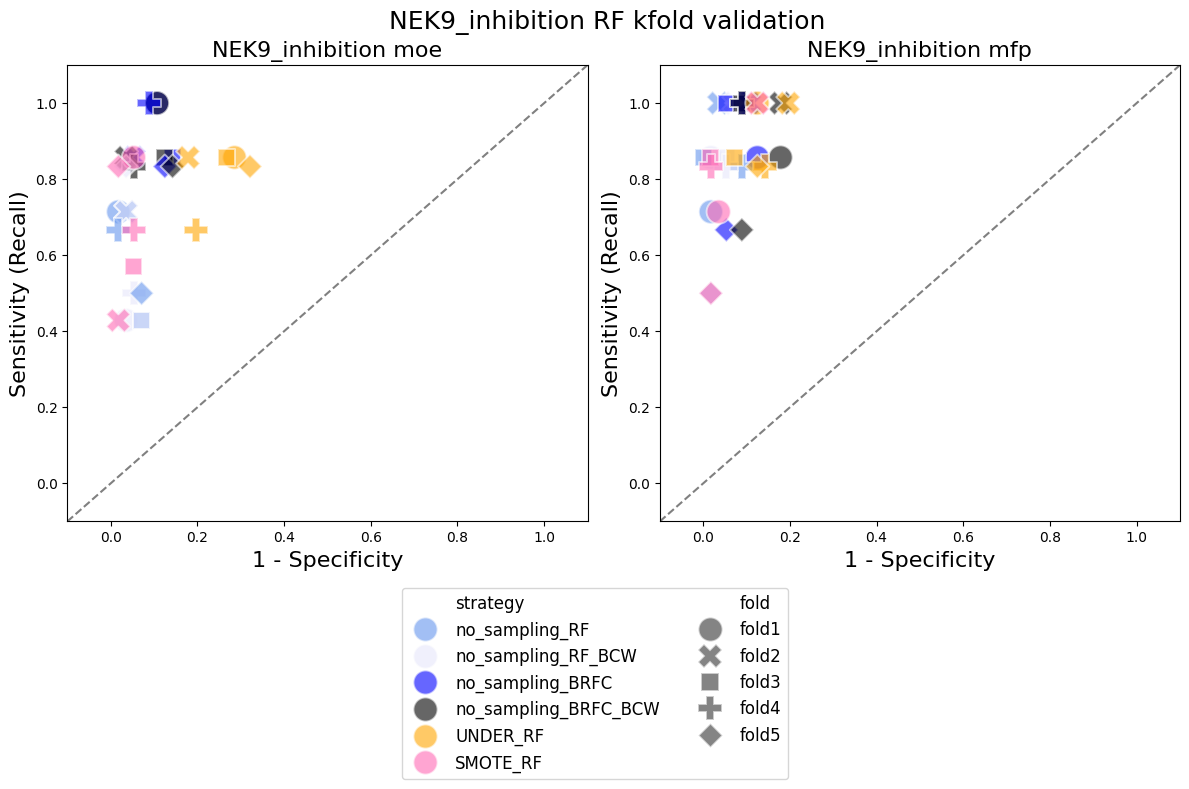

In [79]:
# results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in total_rf['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = total_rf[total_rf['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} RF kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{rf_results}{nek}_RF_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

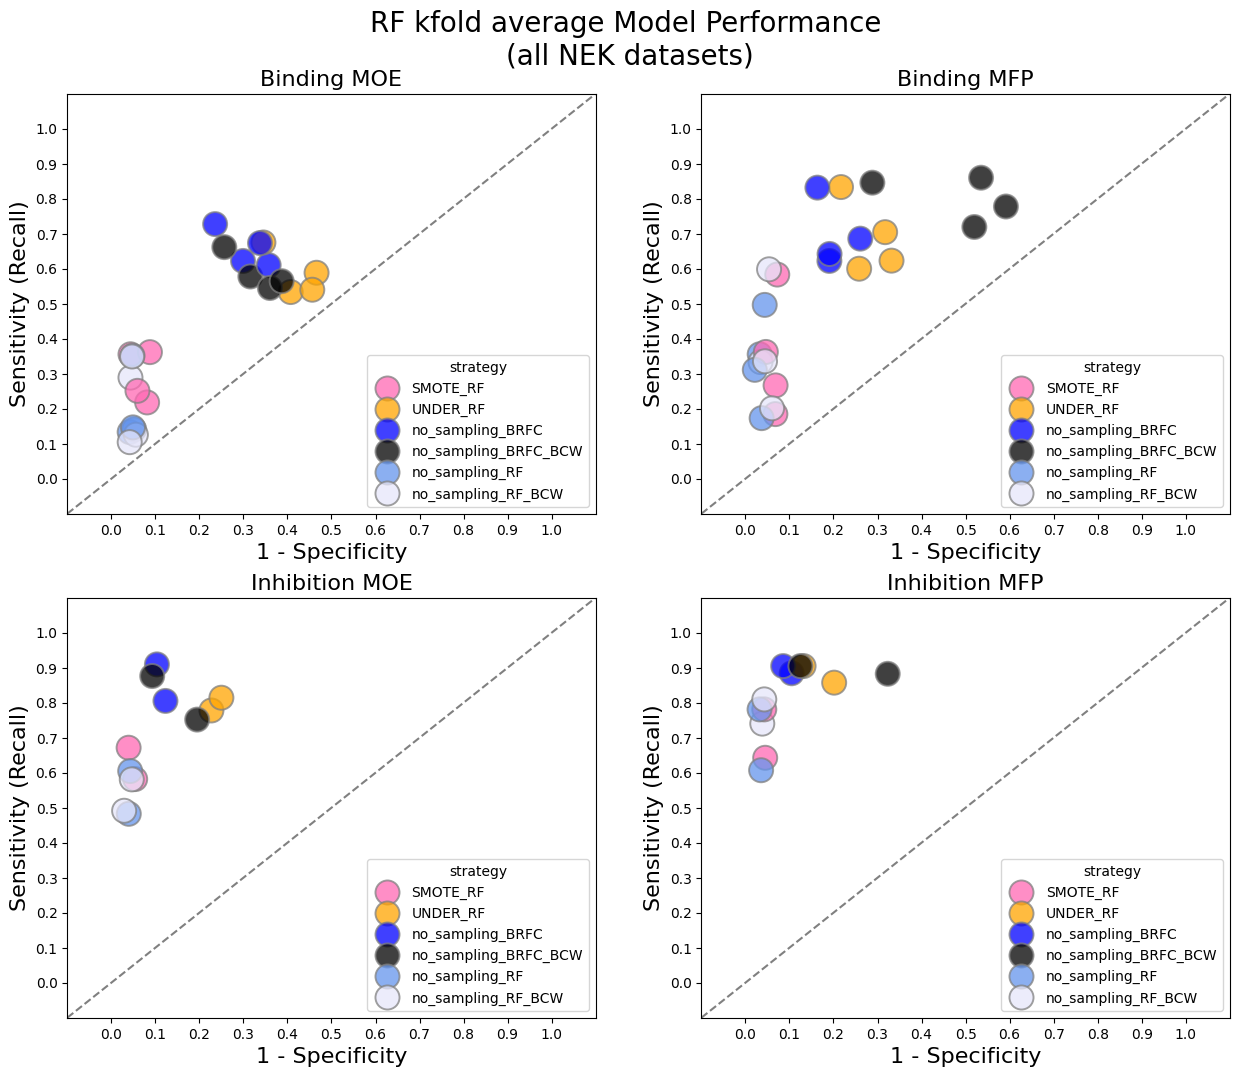

In [80]:
binding_avg = binding.groupby(['NEK','feat_type', 'strategy'])[['recall', '1-specificity']].mean()
binding_avg_df=binding_avg.reset_index()
inhib_avg = inhib.groupby(['NEK','feat_type', 'strategy'])[['recall', '1-specificity']].mean()
inhib_avg_df=inhib_avg.reset_index()
inhib_avg_df
fig, axs = plt.subplots(2,2, figsize=(15,12))

for i, this_df in enumerate(list([binding_avg_df, inhib_avg_df])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette)
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',
                   alpha=0.75, s=300,legend=True, ax=axs[i,1],edgecolor='gray', palette=samp_palette)
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)

plt.suptitle(f'RF kfold average Model Performance \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{rf_results}RF_average_kfold_val.png', bbox_inches='tight')
plt.show();


# GP 

In [16]:
gp_test = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv')
gp_train=pd.read_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv')
def extract_strategy(text, segment_index):
    pattern = rf'^(?:[^_]*_){{{segment_index-1}}}([^_]*)'
    match = re.search(pattern, text)
    return match.group(1) if match else None


gp_test['strategy'] = gp_test['model'].apply(lambda x: extract_strategy(x, 4))
# gp_test=gp_test.drop(columns='Unnamed: 0')
gp_test.to_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv',index=False)
gp_train['strategy'] = gp_train['model'].apply(lambda x: extract_strategy(x, 4))
# gp_train=gp_train.drop(columns='Unnamed: 0')
gp_train.to_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv',index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
gp = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv')
gp['1-specificity']=1-gp['specificity']
gp['nek type'] = gp['NEK'].astype(str).str.split('_').str[1]

gp=gp.replace('none', 'no_sampling')
gp['strategy'] =gp['strategy'].astype(str) +'_'+ gp['kernel_type']

binding_gp = gp[gp['nek type'] == 'binding'] 
inhib_gp = gp[gp['nek type'] == 'inhibition'] 
gp_strategies=['no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern',
       'ADASYN_GP_RBF', 'ADASYN_GP_matern']
gen_colors = ['cornflowerblue', 'orange', 'hotpink','red'] 

for kern in ['RBF','matern']: 
    for samp, color in zip(['no_sampling','UNDER','SMOTE','ADASYN'], gen_colors): 
        gp_type = f'{samp}_GP_{kern}'
        samp_palette[gp_type]=color
    
    

In [45]:
gp['feat_type'].value_counts()

feat_type
MOE    240
MFP    240
Name: count, dtype: int64

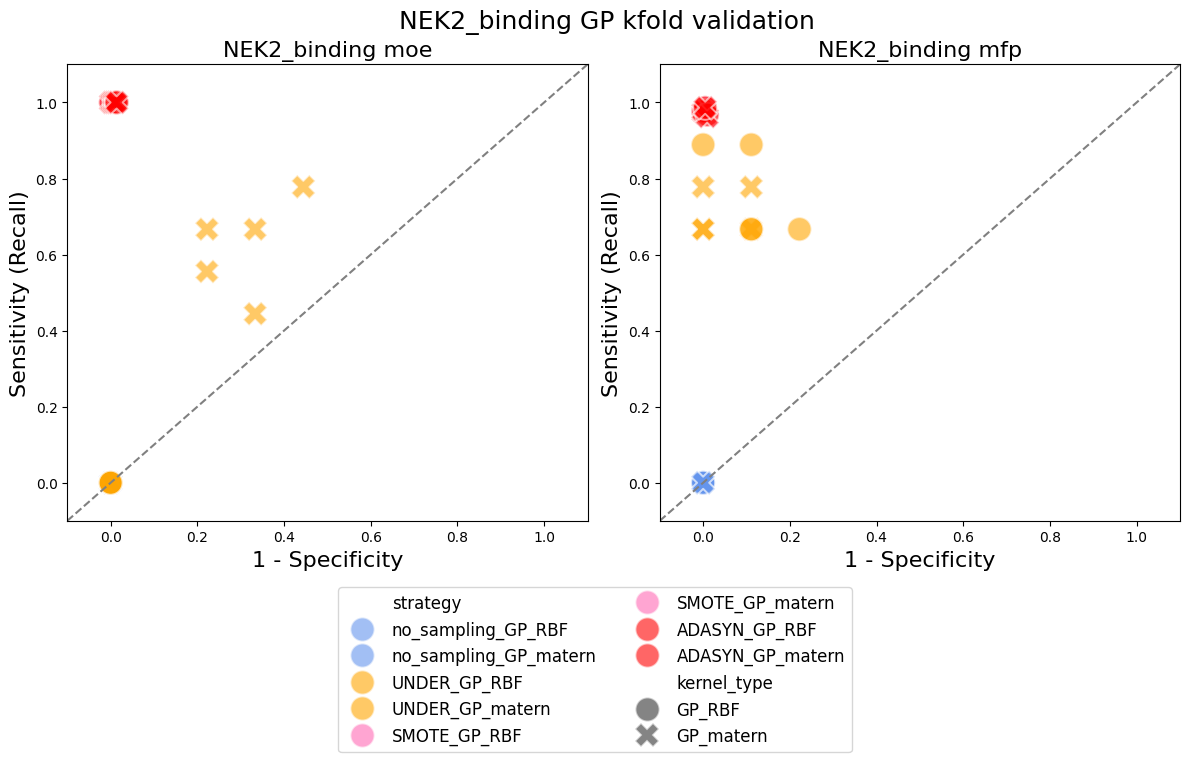

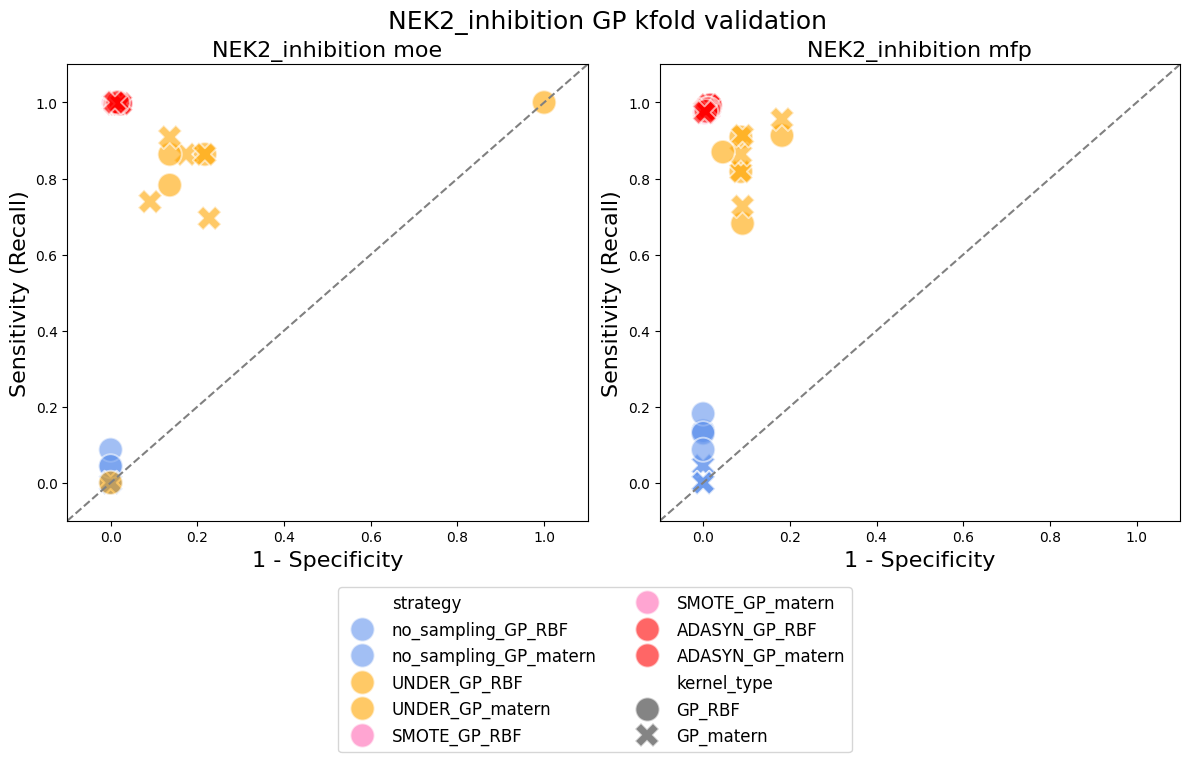

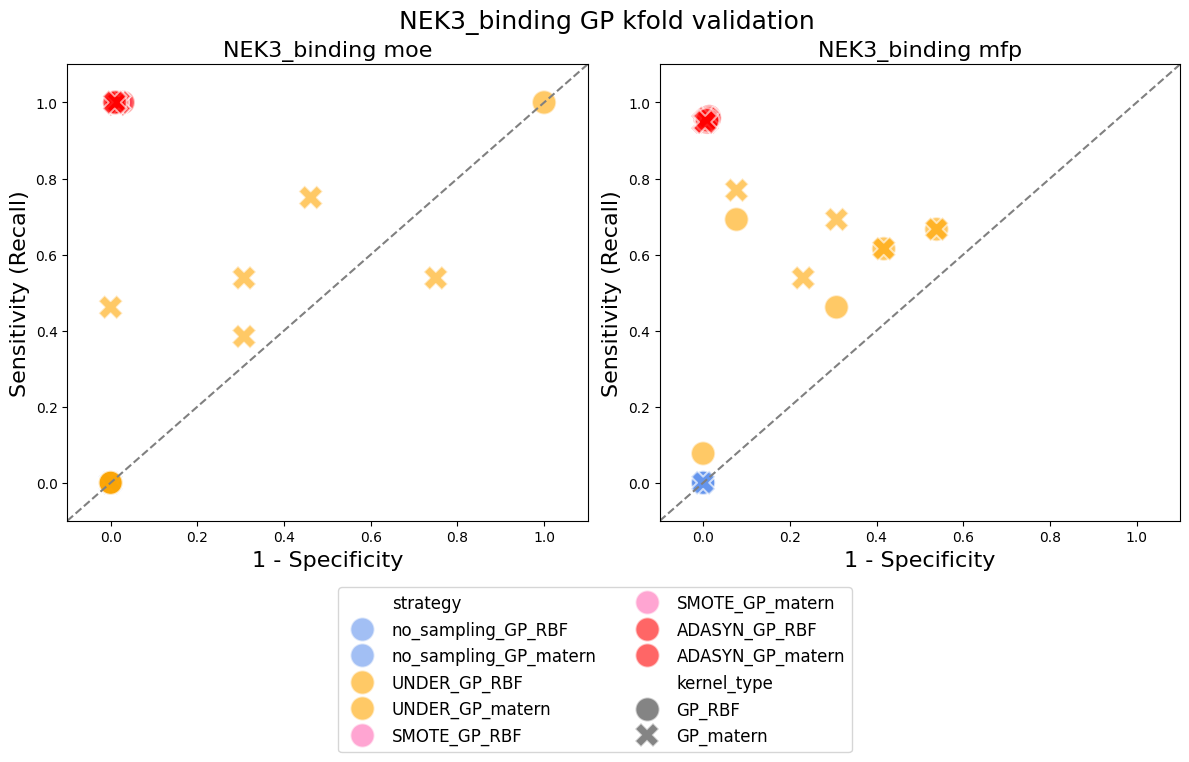

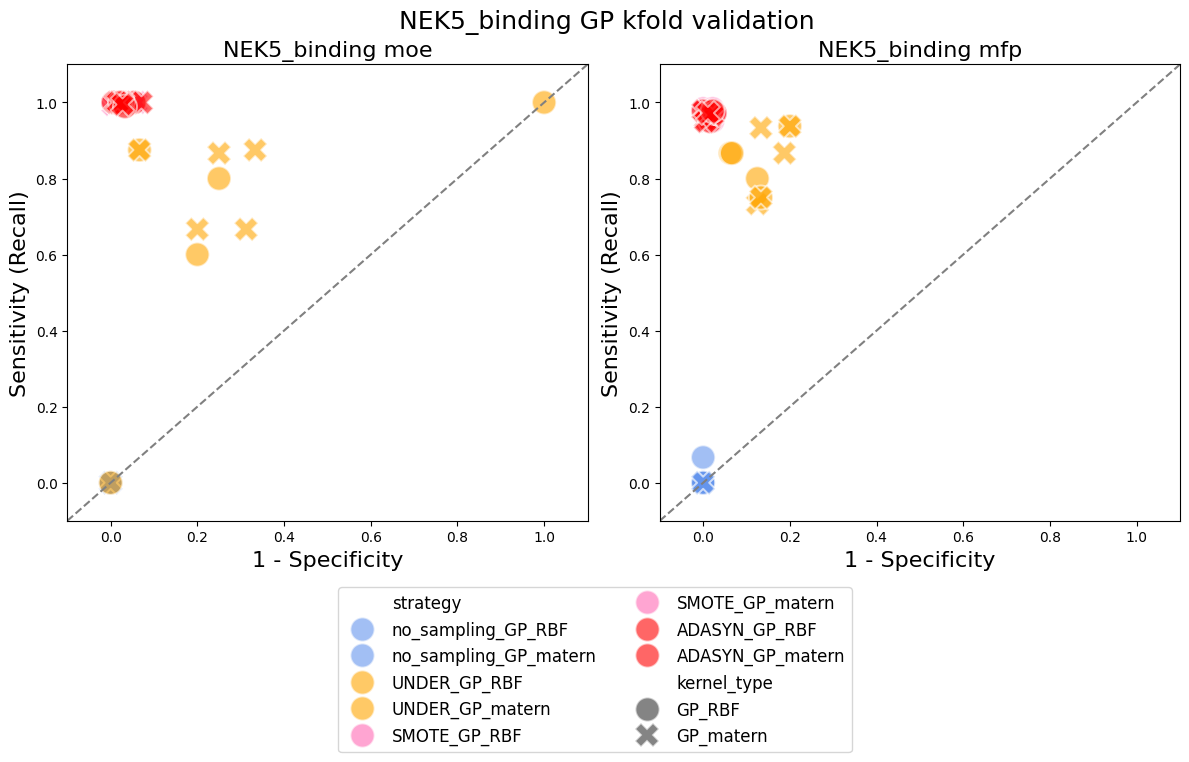

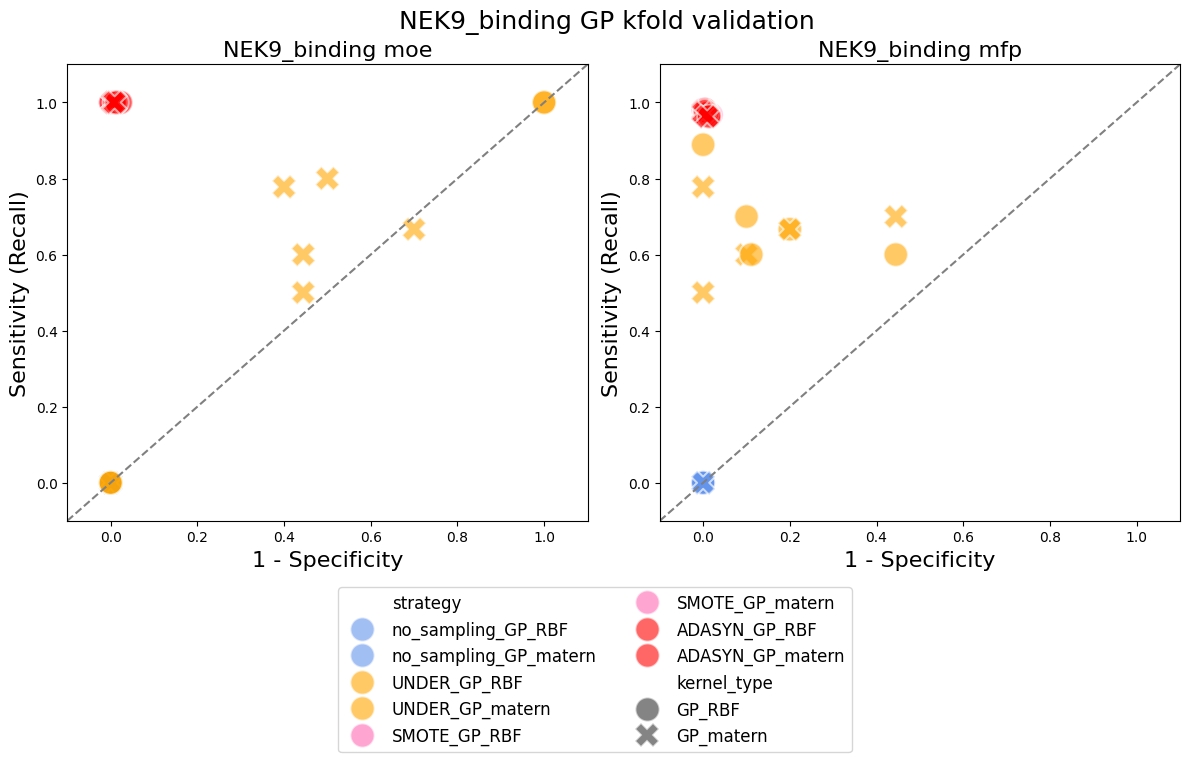

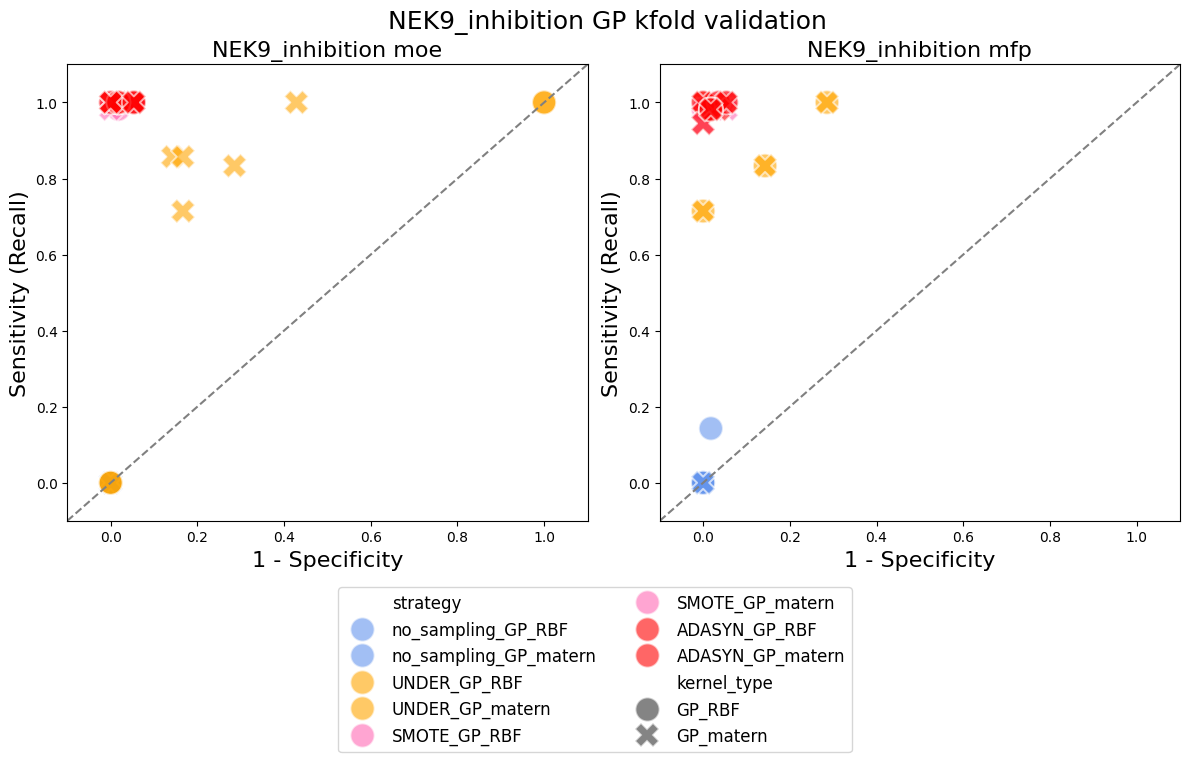

In [48]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]

    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{results_dir2}{nek}_GP_kfold_kernel_types.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

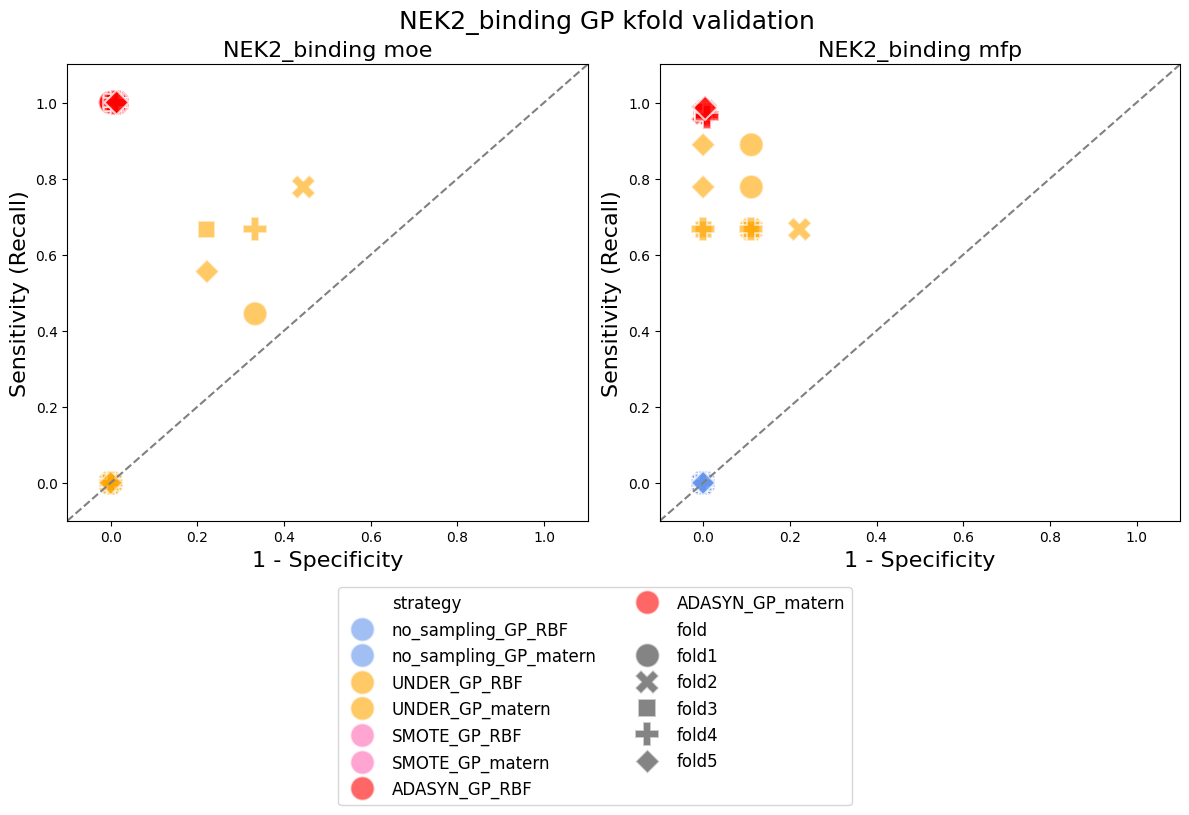

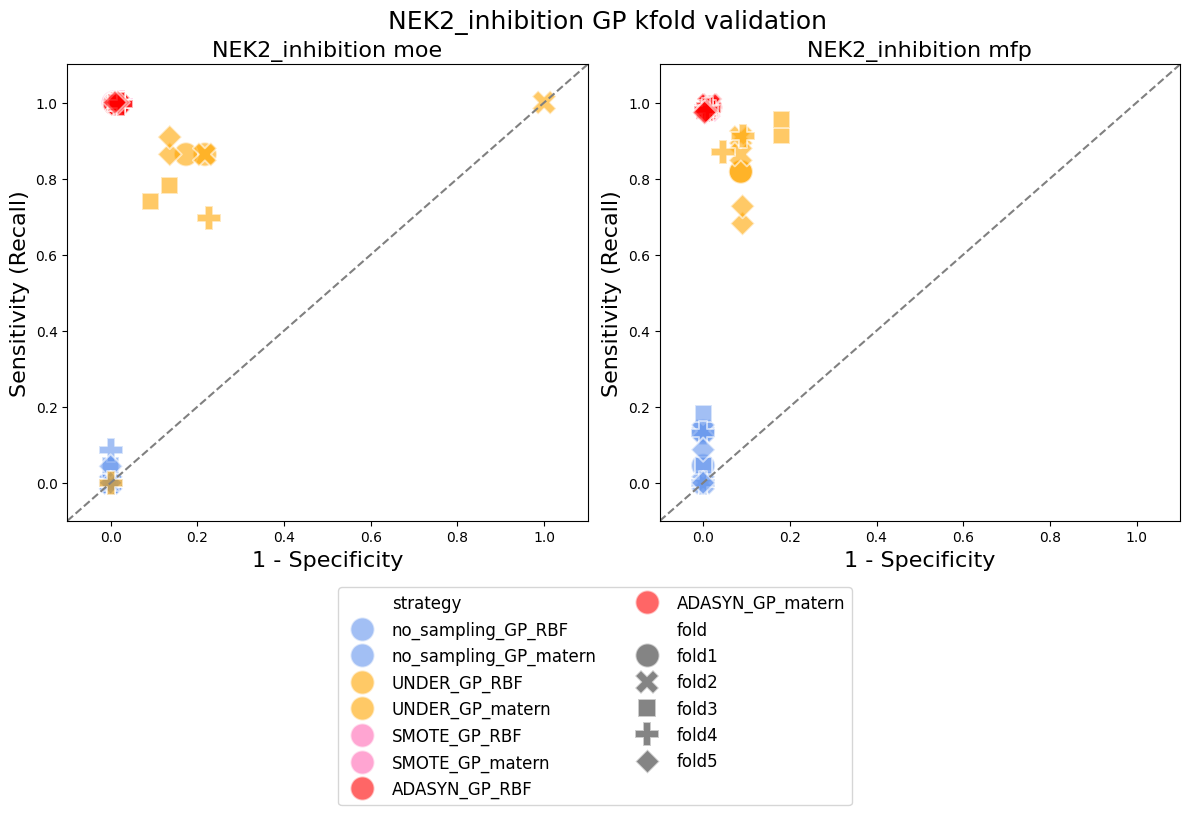

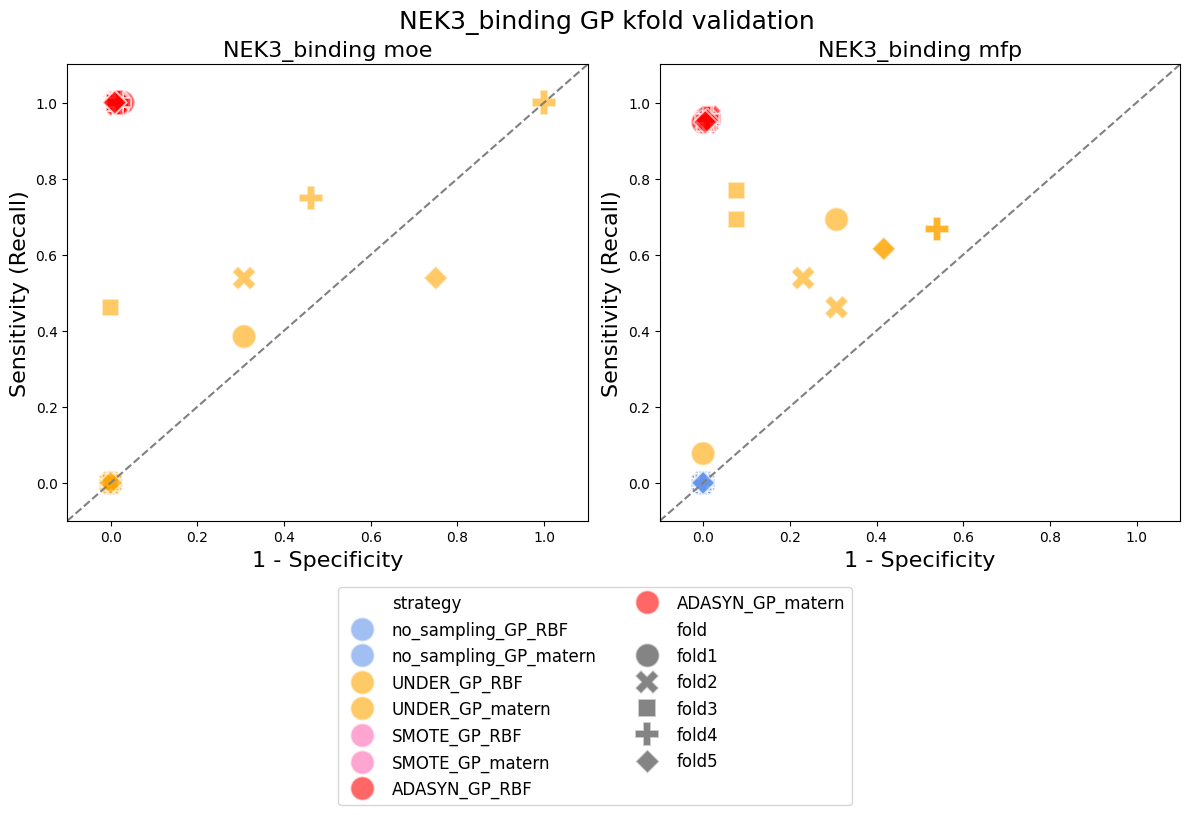

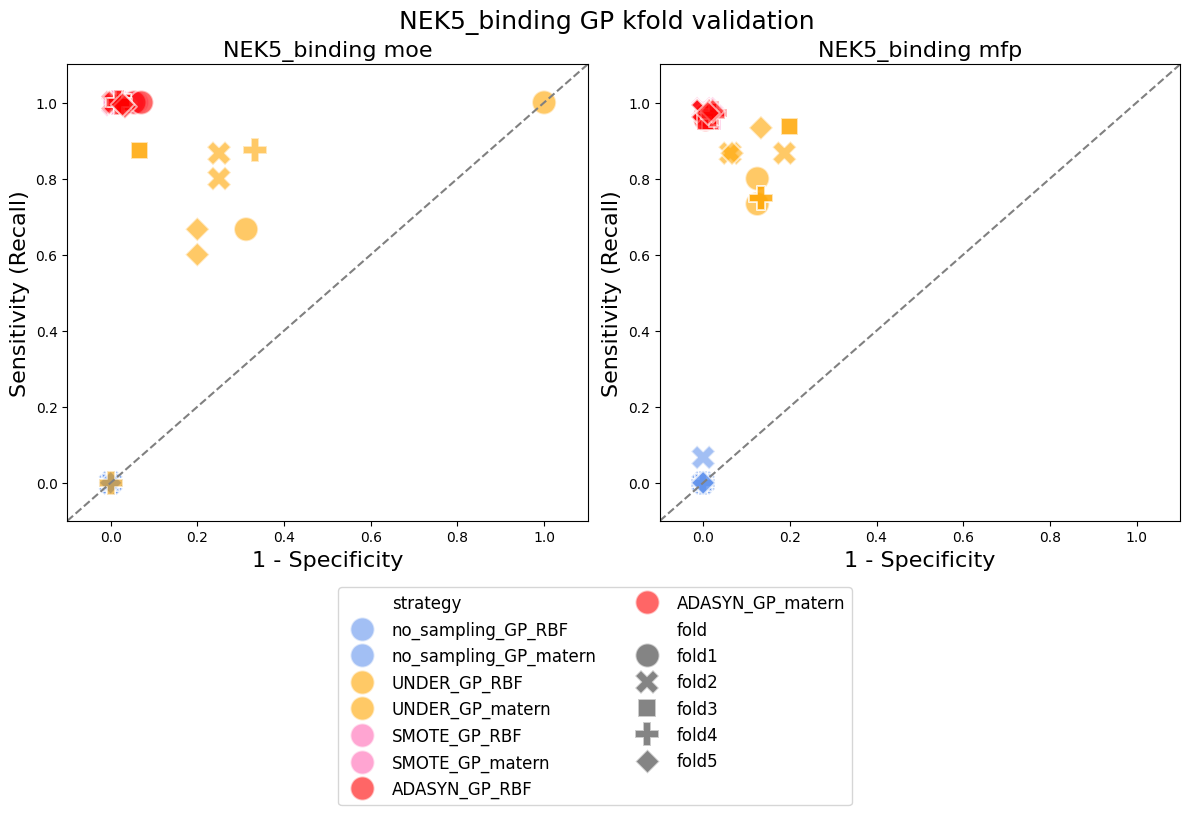

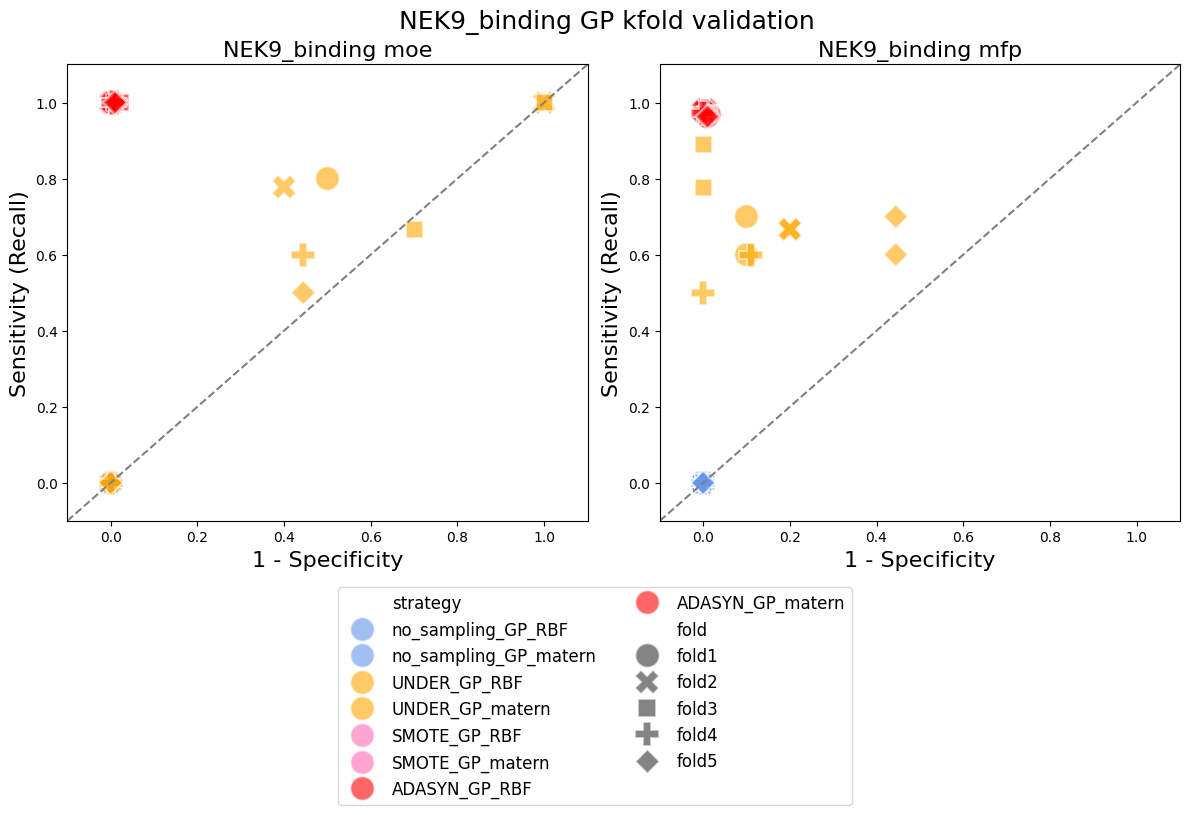

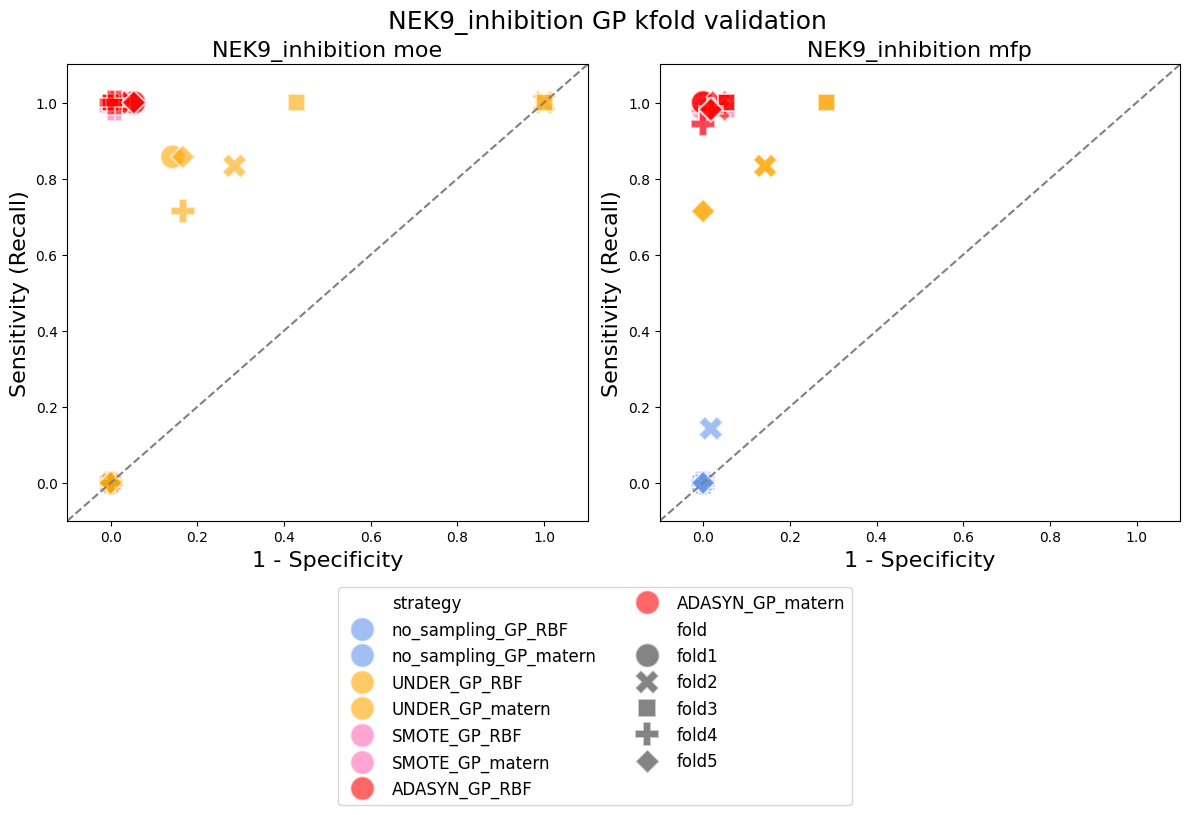

In [42]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{results_dir2}{nek}_GP_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

In [58]:
gp2 = gp.copy() 
gp2['strategy'] = gp2['strategy'].astype(str).apply(lambda x:x.split('_GP_')[0])
gp2

,model,NEK,strategy,feat_type,kernel_type,fold,cm,recall,specificity,accuracy,precision,f1,ROC_AUC,MCC,balanced_accuracy,modeling_type,set,1-specificity,nek type
0,NEK2_binding_MOE_none_scaled_fold1_RBF,NEK2_binding,no_sampling,MOE,GP_RBF,fold1,"[216, 0, 9, 0]",0.000000,1.000000,0.960000,0.000000,0.000000,0.500000,0.000000,0.500000,GP,foldvalidation,0.000000,binding
1,NEK2_binding_MOE_none_scaled_fold1_matern,NEK2_binding,no_sampling,MOE,GP_matern,fold1,"[216, 0, 9, 0]",0.000000,1.000000,0.960000,0.000000,0.000000,0.500000,0.000000,0.500000,GP,foldvalidation,0.000000,binding
2,NEK2_binding_MOE_none_scaled_fold2_RBF,NEK2_binding,no_sampling,MOE,GP_RBF,fold2,"[216, 0, 9, 0]",0.000000,1.000000,0.960000,0.000000,0.000000,0.500000,0.000000,0.500000,GP,foldvalidation,0.000000,binding
3,NEK2_binding_MOE_none_scaled_fold2_matern,NEK2_binding,no_sampling,MOE,GP_matern,fold2,"[216, 0, 9, 0]",0.000000,1.000000,0.960000,0.000000,0.000000,0.500000,0.000000,0.500000,GP,foldvalidation,0.000000,binding
4,NEK2_binding_MOE_none_scaled_fold3_RBF,NEK2_binding,no_sampling,MOE,GP_RBF,fold3,"[216, 0, 9, 0]",0.000000,1.000000,0.960000,0.000000,0.000000,0.500000,0.000000,0.500000,GP,foldvalidation,0.000000,binding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,NEK9_inhibition_MFP_ADASYN_fold3_matern,NEK9_inhibition,ADASYN,MFP,GP_matern,fold3,"[53, 3, 0, 54]",1.000000,0.946429,0.972727,0.947368,0.972973,0.973214,0.946898,0.973214,GP,foldvalidation,0.053571,inhibition
476,NEK9_inhibition_MFP_ADASYN_fold4_RBF,NEK9_inhibition,ADASYN,MFP,GP_RBF,fold4,"[55, 1, 1, 53]",0.981481,0.982143,0.981818,0.981481,0.981481,0.981812,0.963624,0.981812,GP,foldvalidation,0.017857,inhibition
477,NEK9_inhibition_MFP_ADASYN_fold4_matern,NEK9_inhibition,ADASYN,MFP,GP_matern,fold4,"[56, 0, 3, 51]",0.944444,1.000000,0.972727,1.000000,0.971429,0.972222,0.946796,0.972222,GP,foldvalidation,0.000000,inhibition
478,NEK9_inhibition_MFP_ADASYN_fold5_RBF,NEK9_inhibition,ADASYN,MFP,GP_RBF,fold5,"[55, 1, 1, 53]",0.981481,0.982143,0.981818,0.981481,0.981481,0.981812,0.963624,0.981812,GP,foldvalidation,0.017857,inhibition


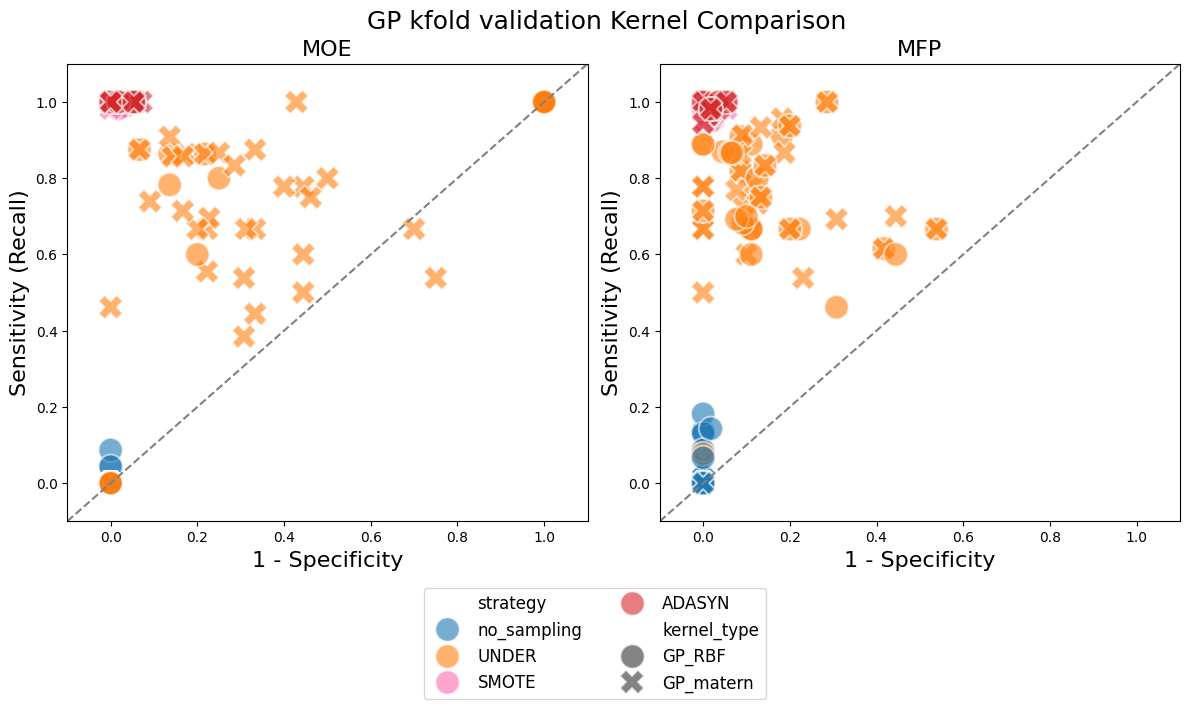

In [61]:

fig, axs = plt.subplots(1,2, figsize=(12,6))


moe_df = gp2[gp2['feat_type'] == 'MOE']
mfp_df =gp2[gp2['feat_type'] == 'MFP']
sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
               s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
              s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
plt.suptitle(f'GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
for i, ax in enumerate(axs): 
    axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xlabel('1 - Specificity', fontsize=16)
    axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)

    
axs[0].set_title(f'MOE', fontsize=16)
axs[1].set_title(f'MFP', fontsize=16)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels,
           loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
axs[0].get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig(f'{results_dir2}GP_RBF_Matern.png',bbox_inches='tight')
plt.tight_layout()
plt.show();

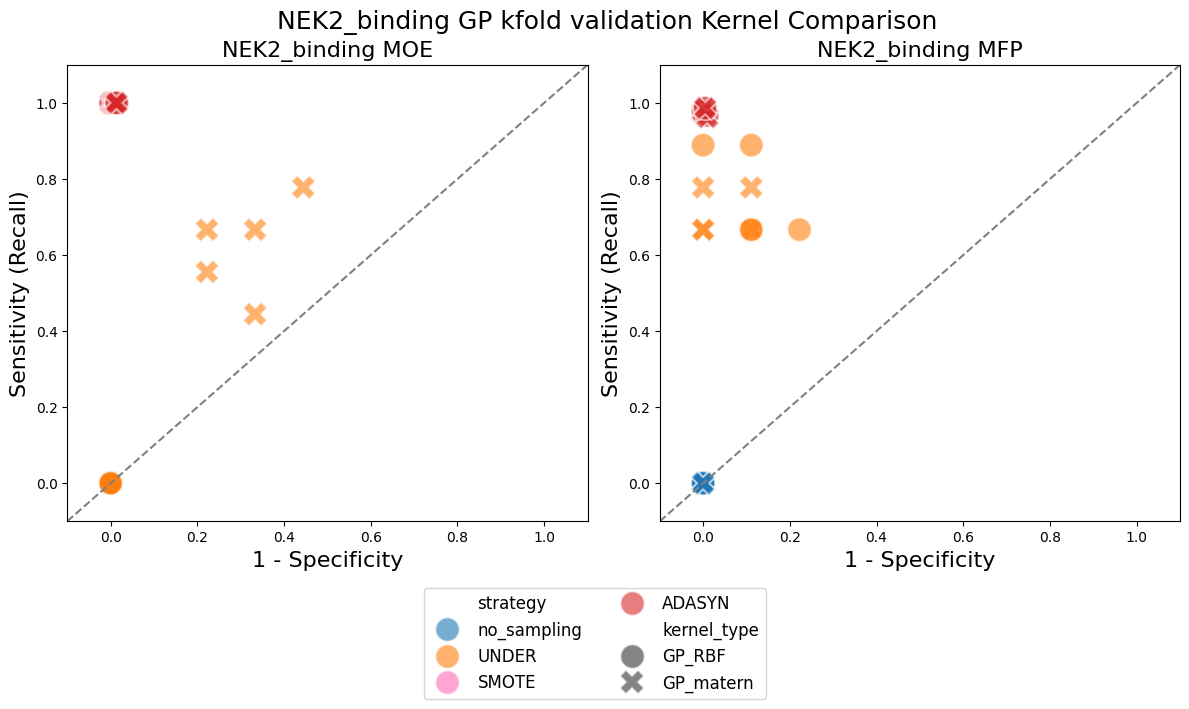

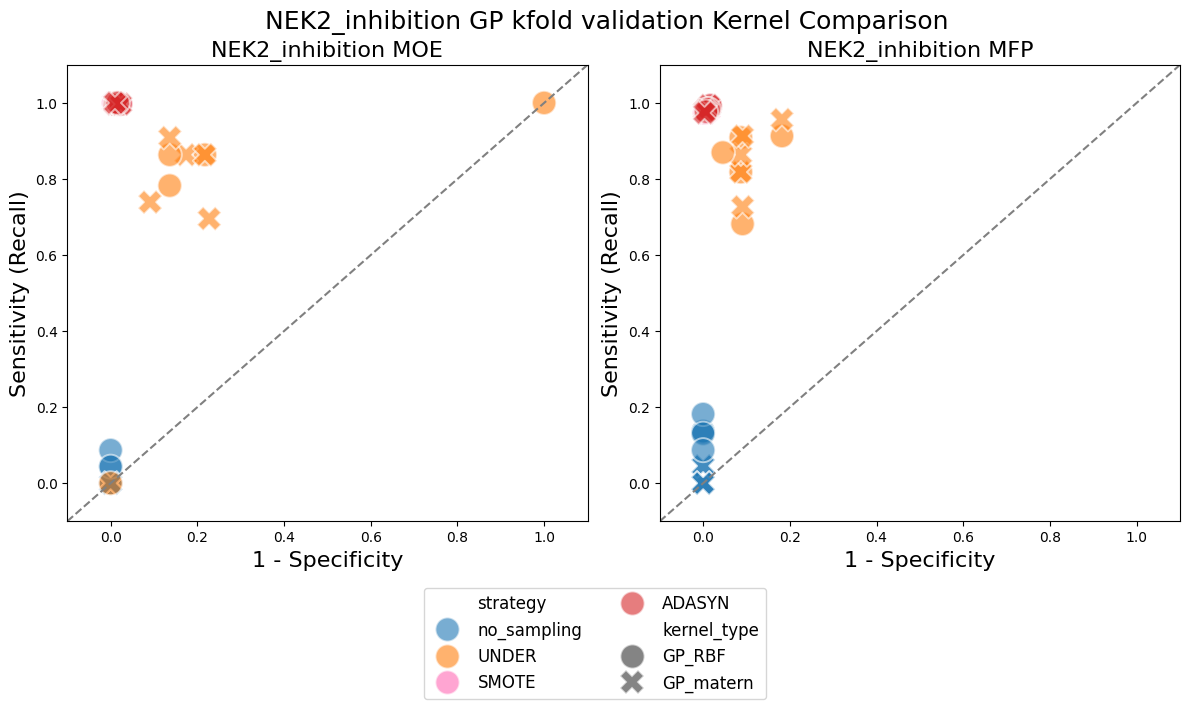

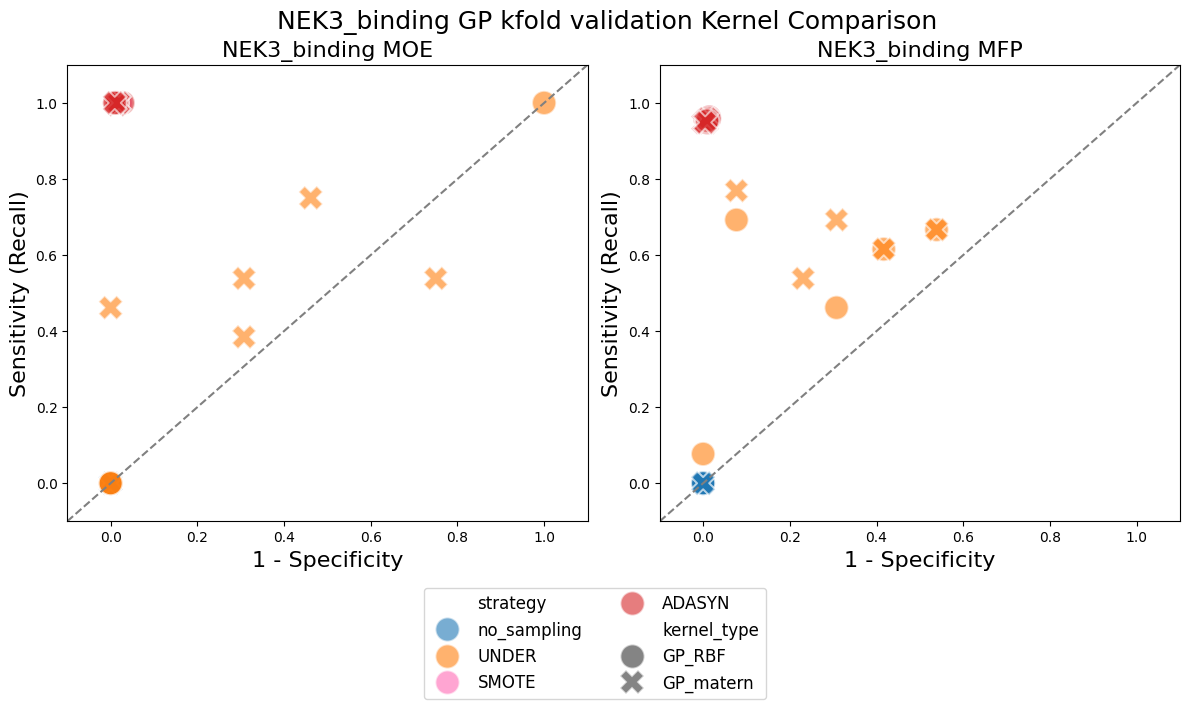

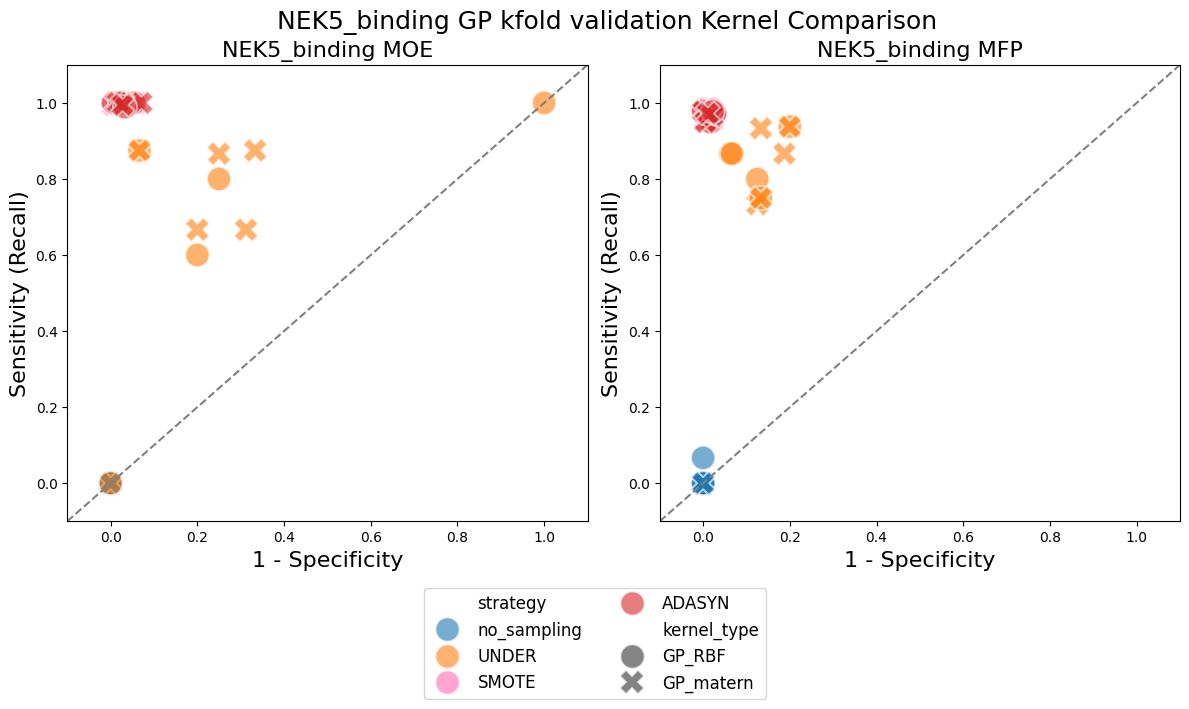

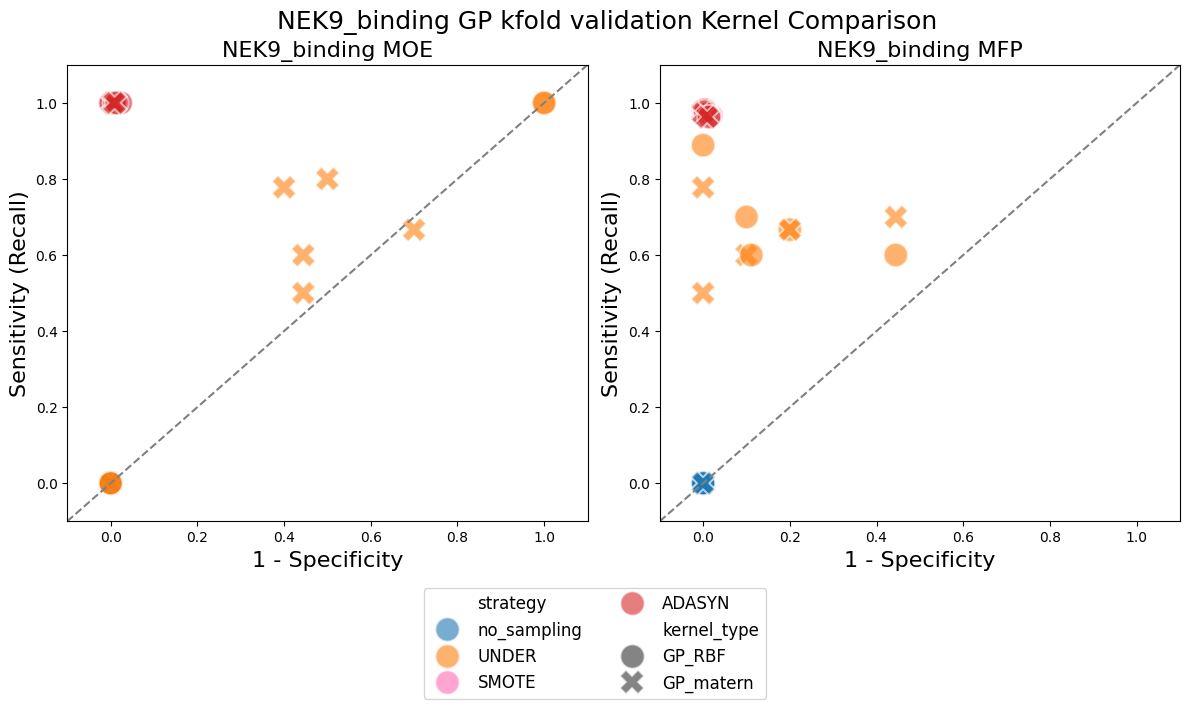

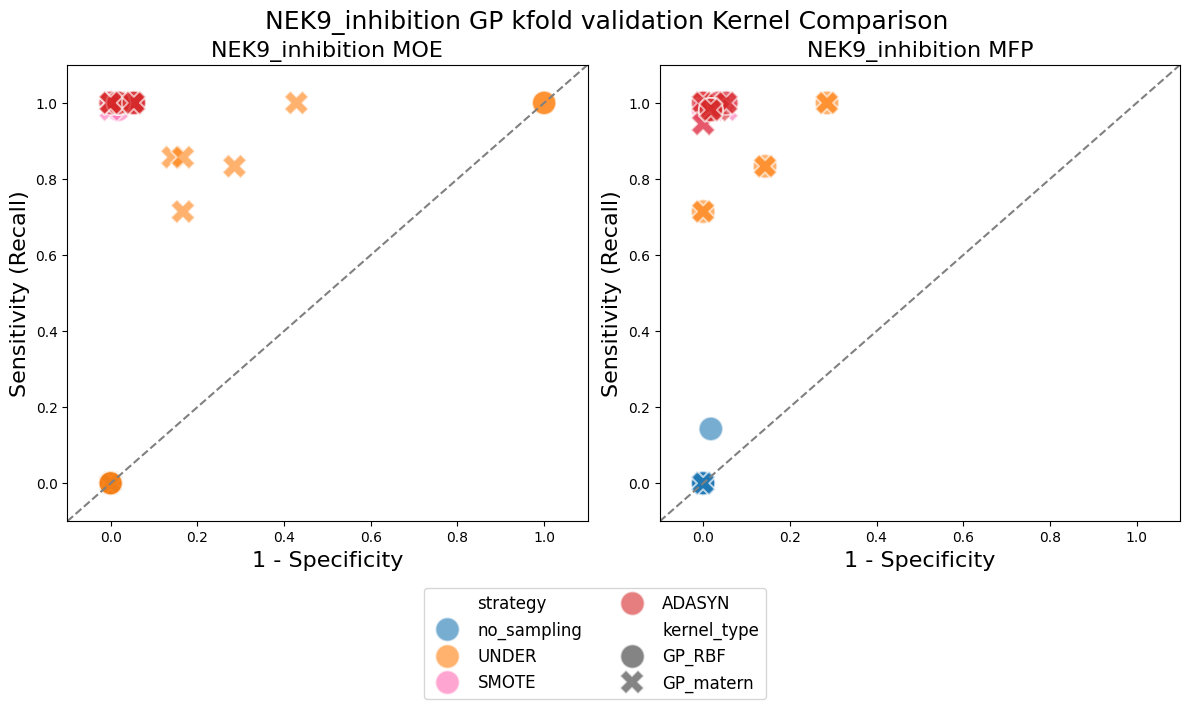

In [63]:
for nek in gp2['NEK'].unique():     
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp2[gp2['NEK'] == nek] 
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df =nek_df[nek_df['feat_type'] == 'MFP']
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} MOE', fontsize=16)
    axs[1].set_title(f'{nek} MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 

    plt.tight_layout()
    plt.show();

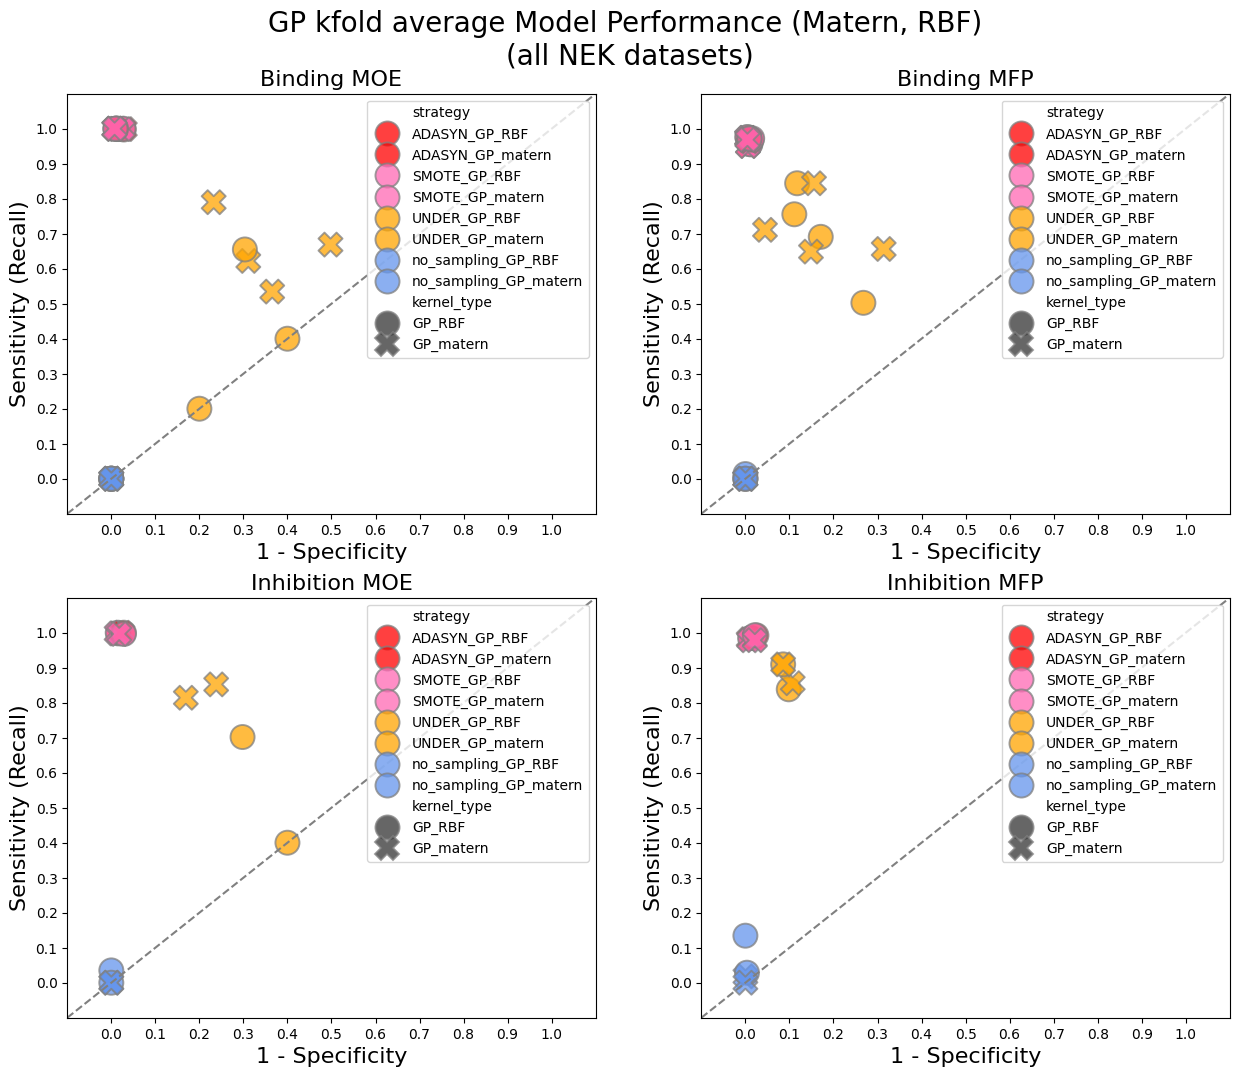

In [73]:
binding_avg_gp = binding_gp.groupby(['NEK','feat_type', 'strategy', 'kernel_type'])[['recall', '1-specificity']].mean()
binding_avg_df_gp=binding_avg_gp.reset_index()
inhib_avg_gp = inhib_gp.groupby(['NEK','feat_type', 'strategy','kernel_type'])[['recall', '1-specificity']].mean()
inhib_avg_df_gp=inhib_avg_gp.reset_index()
inhib_avg_df
fig, axs = plt.subplots(2,2, figsize=(15,12))

for i, this_df in enumerate(list([binding_avg_df_gp, inhib_avg_df_gp])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',  style='kernel_type',
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette)
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   alpha=0.75, s=300,legend=True, ax=axs[i,1],edgecolor='gray', palette=samp_palette)
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)

plt.suptitle(f'GP kfold average Model Performance (Matern, RBF) \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{results_dir2}GP_averages.png', bbox_inches='tight')
plt.show();
